In [1]:
import os
os.chdir("../")

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from cids.model import MaskedTransformerEncoder
from cids.data import OpTCDataset

In [15]:
device = "cuda:0"
window = 128
embedding = nn.Linear(102, 64)
head = nn.Linear(64, 102)
config = {"ds_name": "hids-v5_201_train",
        "parts": 16,
        "window_size": window,
        "shuffle": True}
dl = torch.utils.data.DataLoader(OpTCDataset(**config), batch_size = 64)



In [16]:
model = MaskedTransformerEncoder(
    n_layer=6,
    mean_masked_length=3,
    masking_ratio=0.15,
    embedding=embedding,
    head=head,
    d_model= 64,
    dim_feedforward=128,
    window_size=window
)
model = model.to(device)

In [17]:
for inp in dl:
    print(inp.shape)
    inp = inp.to(device)
    out, mask = model(inp)

    break

torch.Size([64, 128, 102])


In [18]:
print(mask.shape)

# Calculate the average length of continuous 0s over the time dimension
def average_continuous_zeros(mask):
    batch_size, time_steps, features = mask.shape
    avg_lengths = []
    
    for b in range(batch_size):
        for f in range(features):
            lengths = []
            current_length = 0
            for t in range(time_steps):
                if mask[b, t, f] == 0:
                    current_length += 1
                else:
                    if current_length > 0:
                        lengths.append(current_length)
                    current_length = 0
            if current_length > 0:
                lengths.append(current_length)
            if lengths:
                avg_lengths.append(sum(lengths) / len(lengths))
    
    return sum(avg_lengths) / len(avg_lengths) if avg_lengths else 0

avg_length = average_continuous_zeros(mask.cpu().numpy())
print(f"Average length of continuous 0s: {avg_length}")

torch.Size([64, 128, 102])
Average length of continuous 0s: 3.0967431006493507


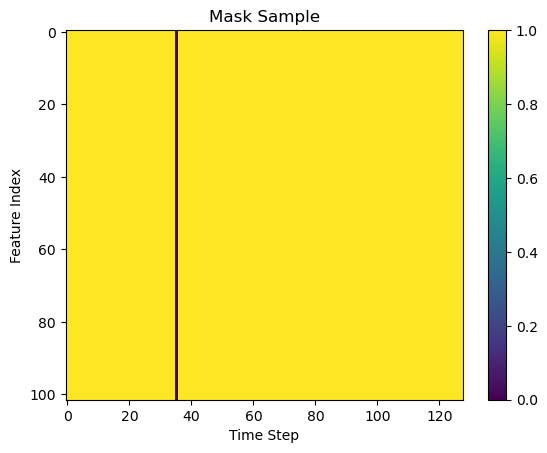

In [19]:

for i in range(1):
    # Select the first sample from the mask tensor
    mask_sample = mask[i].cpu().numpy().T

    # Plot the mask sample
    plt.imshow(mask_sample, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Mask Sample')
    plt.xlabel('Time Step')
    plt.ylabel('Feature Index')
    plt.show()

(64, 128)


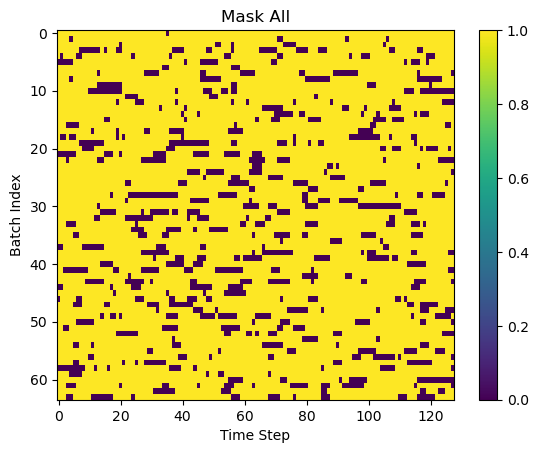

In [20]:
mask_all = mask.cpu().numpy()[:, :, 0]
print(mask_all.shape)

plt.imshow(mask_all, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Mask All')
plt.xlabel('Time Step')
plt.ylabel("Batch Index")
plt.show()